**Libraries Needed**  
numpy  
jieba  
gensim  
tensorflow  
matplotlib  

In [26]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")

**预训练词向量**  
本教程使用了北京师范大学中文信息处理研究所与中国人民大学 DBIIR 实验室的研究者开源的"chinese-word-vectors" github链接为：  
https://github.com/Embedding/Chinese-Word-Vectors  
如果你不知道word2vec是什么，我推荐以下一篇文章：  
https://zhuanlan.zhihu.com/p/26306795  
这里我们使用了"chinese-word-vectors"知乎Word + Ngram的词向量，可以从上面github链接下载，我们先加载预训练模型并进行一些简单测试：

In [16]:
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('../sgns.zhihu.bigram', 
                                          binary=False)

**词向量模型**  
在这个词向量模型里，每一个词是一个索引，对应的是一个长度为300的向量，我们今天需要构建的LSTM神经网络模型并不能直接处理汉字文本，需要先进行分次并把词汇转换为词向量，步骤请参考下图，步骤的讲解会跟着代码一步一步来，如果你不知道RNN，GRU，LSTM是什么，我推荐deeplearning.ai的课程，网易公开课有免费中文字幕版，但我还是推荐有习题和练习代码部分的的coursera原版

In [5]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['孔子'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))
cn_model['孔子']

词向量的长度为300


array([-0.459174,  0.511711, -0.510548,  0.49795 ,  0.764954, -0.871935,
       -0.335191,  0.323417,  0.145888, -0.010004,  0.413674,  0.655862,
       -0.239163, -0.202137,  0.285477,  0.607521, -0.295878,  0.473641,
        0.657034,  0.209643,  0.060934,  0.341491,  0.179213, -0.928412,
       -1.309496,  0.667487,  0.60432 , -0.215458,  0.556134,  1.013507,
        0.236438,  0.490978, -0.324118,  0.827709, -0.633155, -0.125863,
        0.399796,  0.295161, -0.437671,  0.012822,  0.073047,  0.891576,
       -0.434772,  0.428342,  0.285875, -0.613697,  0.808781,  0.0556  ,
        0.417876,  0.615605, -0.399464,  0.127042, -0.476437, -0.55382 ,
       -1.051466, -0.185181,  0.148764,  0.363053, -0.445998, -0.281756,
       -0.209169, -0.233683, -0.271602,  0.225867, -0.583228,  0.807539,
        0.19152 ,  0.621448, -0.882431,  0.387011, -0.120132, -0.180161,
        0.612972, -0.244528, -0.208375, -0.125486, -0.53498 ,  0.034153,
        0.434322, -1.209   , -0.669831,  0.86926 , 

In [6]:
# 计算相似度
cn_model.similarity('老子', '我')

0.37086627

In [7]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['中国'], topn=20)

[('我国', 0.6130719184875488),
 ('天朝', 0.5357025861740112),
 ('美国', 0.5048182010650635),
 ('中国人', 0.5000995993614197),
 ('本国', 0.4976556897163391),
 ('印度', 0.49548032879829407),
 ('日本', 0.491807758808136),
 ('国内', 0.4640890955924988),
 ('大陆', 0.4627026915550232),
 ('中华民族', 0.43461209535598755),
 ('外国', 0.43234753608703613),
 ('周边国家', 0.4288373291492462),
 ('台湾地区', 0.427590012550354),
 ('韩国', 0.42619460821151733),
 ('东亚国家', 0.42446058988571167),
 ('蒙古国', 0.42360609769821167),
 ('亚洲', 0.4225274920463562),
 ('亚洲各国', 0.4225262403488159),
 ('欧州', 0.4184926748275757),
 ('国人', 0.4143391251564026)]

In [8]:
# 找出不同的词
test_words = '孔丘 圣人 孔子 孟子 孔子 荀子'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 孔丘 圣人 孔子 孟子 孔子 荀子 中:
不是同一类别的词为: 圣人


In [9]:
cn_model.most_similar(positive=['女人','出轨'], negative=['男人'], topn=10)

[('劈腿', 0.5849199295043945),
 ('婚外情', 0.5557921528816223),
 ('偷情', 0.5555664300918579),
 ('外遇', 0.5458645820617676),
 ('再婚', 0.5422405004501343),
 ('未婚先孕', 0.5357398986816406),
 ('隐婚', 0.5257365703582764),
 ('离婚', 0.524539053440094),
 ('马蓉', 0.5239365696907043),
 ('通奸', 0.5222055912017822)]

In [29]:
# 获得样本的索引，样本存放于两个文件夹中，
# 分别为 正面评价'pos'文件夹 和 负面评价'neg'文件夹
# 每个文件夹中有2000个txt文件，每个文件中是一例评价
import os
pos_txts = os.listdir('../Questionnaire Review/pos')
neg_txts = os.listdir('../Questionnaire Review/neg')

In [30]:
print( '样本总共: '+ str(len(pos_txts) + len(neg_txts)) )

样本总共: 989


In [31]:
# 现在我们将所有的评价内容放置到一个list里

train_texts_orig = [] # 存储所有评价，每例评价为一条string

# 添加完所有样本之后，train_texts_orig为一个含有4000条文本的list
# 其中前2000条文本为正面评价，后2000条为负面评价

for i in range(len(pos_txts)):
    with open('../Questionnaire Review/pos/'+pos_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('../Questionnaire Review/neg/'+neg_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()

In [32]:
train_texts_orig

['ڹݽһ',
 'Ȥ',
 '̧ܣ˼˵ǷȷӦ',
 'ѧϰ',
 'ȥһηлҪһʽЬС һ¸о',
 'ѧϰ \uedfd',
 'Ҫӵ٧ͺˣǻһ',
 'Ůȥ',
 'ѧϰ',
 'ѧϰand',
 '',
 'ճ\ue8ec',
 'ллǳĵʹ',
 '˵ лл㣬¿λ',
 'ܺÿ',
 'ƽȴҸ',
 'ޱȵķḻϲŭ',
 'ǳ׳',
 'ۣллձؽ',
 '',
 '110',
 'ҹ',
 '䡣',
 'Ư',
 'õĲҲ',
 'ӹл',
 '',
 'Լһ',
 '˼',
 'лл',
 'ѧϰŮ',
 'Ϸ',
 'Լϲ˺Լ\uec2eˣξѣȻһһЩ',
 'һȥһİĳεһ',
 'Ϸ',
 '˭һ',
 'ʱ',
 'everything',
 'һ',
 'Ƶزģbվupף',
 'ԣճ',
 'úѧϰ',
 'ԾͶԿ㼺',
 'ѧʱ䴩',
 'ճѧϰ',
 'ϣܸıԼĿһ',
 'ʵĶйϵѧϰᣬãЩȤ顭 ӾͶ',
 'ǧҪˮȺ˺ìܰ""""Ȼ˯""""Ҫ',
 'ȡ֮',
 'ʲô',
 'ѧϰ',
 'ѧϰ',
 'Ʒ˺ѿǵ\u07b8',
 'лл',
 'ƽƽӹһЩССĲ۵պҸ',
 'excitedenthusiastic',
 'ܺ',
 'һʼ˸Լ˸ңһֻȫ̿',
 'лл',
 'ұ˰æ',
 'лмؽİ',
 'һ\U0003fe7a',
 'Ȱ˵',
 '˲ôܴ\U000b2ef9\u07b9˲\u0cbbڵĻӦðʵڲд\U000b2ef9˶ܵڰ',
 'ħЩƷתƵԶĵط',
 '110',
 '',
 'Ҫѧϰ',
 'ܸ',
 'ù˵лл',
 'лл',
 'ܿģҲûһЩķ',
 '۵',
 '˿',
 'ճ',
 'ʵԼԸ',
 'ȥһEd Sheeranݳ',
 'κ',
 '',
 'Ҳʱɣÿ˶ѡ\U00076f38ñ',
 'һ㶼ںͬѧļҳȥʲôȥʲô',
 'ʲôʲô',
 'κιĵ飬ͨŻNBA',
 'һǸ˿ʼ֤',
 '˶ ʱ ѧϰ',
 'һȥȫ',
 'ڴ',
 'һͬ',
 'ͺ',
 'ѧϰ',
 'ȥ',
 '',
 'ѧϰ\ue8ec֣ţ磬ѧУ',
 '',
 'ֵ',
 '',
 'ӹ thank you',
 'лл',
 '',
 'Ҹһ˳',
 'ʮѤ',
 '',
 '',
 'cС

In [20]:
len(train_texts_orig)

989

In [21]:
# 我们使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

**分词和tokenize**  
首先我们去掉每个样本的标点符号，然后用jieba分词，jieba分词返回一个生成器，没法直接进行tokenize，所以我们将分词结果转换成一个list，并将它索引化，这样每一例评价的文本变成一段索引数字，对应着预训练词向量模型中的词。

In [22]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有4000个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\EdiC\AppData\Local\Temp\jieba.cache
Loading model cost 0.994 seconds.
Prefix dict has been built succesfully.


**索引长度标准化**  
因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [23]:
# 获得所有tokens的长度
num_tokens = [len(tokens) for tokens in train_tokens]
num_tokens = np.array(num_tokens)

In [24]:
# 平均tokens的长度
np.mean(num_tokens)

4.950455005055612

In [25]:
# 最长的评价tokens的长度
np.max(num_tokens)

58

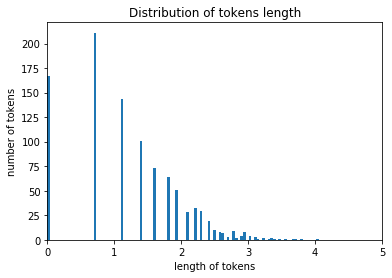

In [27]:
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,5))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [28]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

15

In [29]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9534883720930233

**反向tokenize**  
我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。

In [30]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [34]:
reverse = reverse_tokens(train_tokens[9])

以下可见，训练样本的极性并不是那么精准，比如说下面的样本，对早餐并不满意，但被定义为正面评价，这会迷惑我们的模型，不过我们暂时不对训练样本进行任何修改。

In [35]:
# 经过tokenize再恢复成文本
# 可见标点符号都没有了
reverse

'干了一番惊天动地的事情但最后回归宁静满足死而无憾'

In [37]:
# 原始文本
train_texts_orig[9]

'干了一番惊天动地的事情，但最后回归宁静，满足，死而无憾'

**准备Embedding Matrix**  
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为$(numwords, embeddingdim)$的矩阵，num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示。  
注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [38]:
embedding_dim

300

In [39]:
# 只使用前20000个词
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [40]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

300

In [41]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(50000, 300)

**padding（填充）和truncating（修剪）**  
我们把文本转换为tokens（索引）之后，每一串索引的长度并不相等，所以为了方便模型的训练我们需要把索引的长度标准化，上面我们选择了236这个可以涵盖95%训练样本的长度，接下来我们进行padding和truncating，我们一般采用'pre'的方法，这会在文本索引的前面填充0，因为根据一些研究资料中的实践，如果在文本索引后面填充0的话，会对模型造成一些不良影响。

In [42]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [43]:
# 超出五万个词向量的词用0代替
train_pad[ train_pad>=num_words ] = 0

In [44]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 926, 769,
       156,  12])

In [48]:
# 准备target向量，前989样本为1，后2000为0
train_target = np.concatenate( (np.ones(641),np.zeros(348)) )

In [49]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [50]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [51]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[35]))
print('class: ',y_train[35])

            闲聊生活学习
class:  1.0


现在我们用keras搭建LSTM模型，模型的第一层是Embedding层，只有当我们把tokens索引转换为词向量矩阵之后，才可以用神经网络对文本进行处理。
keras提供了Embedding接口，避免了繁琐的稀疏矩阵操作。   
在Embedding层我们输入的矩阵为：$$(batchsize, maxtokens)$$
输出矩阵为： $$(batchsize, maxtokens, embeddingdim)$$

In [52]:
# 用LSTM对样本进行分类
model = Sequential()

In [53]:
# 模型第一层为embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

Instructions for updating:
Colocations handled automatically by placer.


In [54]:
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

**构建模型**  
我在这个教程中尝试了几种神经网络结构，因为训练样本比较少，所以我们可以尽情尝试，训练过程等待时间并不长：  
**GRU：**如果使用GRU的话，测试样本可以达到87%的准确率，但我测试自己的文本内容时发现，GRU最后一层激活函数的输出都在0.5左右，说明模型的判断不是很明确，信心比较低，而且经过测试发现模型对于否定句的判断有时会失误，我们期望对于负面样本输出接近0，正面样本接近1而不是都徘徊于0.5之间。  
**BiLSTM：**测试了LSTM和BiLSTM，发现BiLSTM的表现最好，LSTM的表现略好于GRU，这可能是因为BiLSTM对于比较长的句子结构有更好的记忆，有兴趣的朋友可以深入研究一下。  
Embedding之后第，一层我们用BiLSTM返回sequences，然后第二层16个单元的LSTM不返回sequences，只返回最终结果，最后是一个全链接层，用sigmoid激活函数输出结果。

In [55]:
# GRU的代码
# model.add(GRU(units=32, return_sequences=True))
# model.add(GRU(units=16, return_sequences=True))
# model.add(GRU(units=4, return_sequences=False))

In [56]:
model.add(Dense(1, activation='sigmoid'))
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=1e-3)

In [57]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [58]:
# 我们来看一下模型的结构，一共90k左右可训练的变量
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 300)           15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 64)            85248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 15,090,449
Trainable params: 90,449
Non-trainable params: 15,000,000
_________________________________________________________________


In [59]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [60]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [61]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [62]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)

In [63]:
# 定义callback函数
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [64]:
# 开始训练
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Train on 801 samples, validate on 89 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
768/801 [===========================>..] - ETA: 0s - loss: 0.6677 - acc: 0.6367
Epoch 00001: val_loss improved from inf to 0.59371, saving model to sentiment_checkpoint.keras
801/801 [==============================] - 3s 4ms/sample - loss: 0.6640 - acc: 0.6355 - val_loss: 0.5937 - val_acc: 0.7416
Epoch 2/20
768/801 [===========================>..] - ETA: 0s - loss: 0.6103 - acc: 0.6875
Epoch 00002: val_loss improved from 0.59371 to 0.57703, saving model to sentiment_checkpoint.keras
801/801 [==============================] - 1s 862us/sample - loss: 0.6082 - acc: 0.6891 - val_loss: 0.5770 - val_acc: 0.7303
Epoch 3/20
768/801 [===========================>..] - ETA: 0s - loss: 0.5847 - acc: 0.6706
Epoch 00003: val_loss improved from 0.57703 to 0.56270, saving model to sentiment_checkpoint.keras
801/801 [==============================] - 1s 920us/sample - loss: 0.5830 - acc: 0.6704 - val

**结论**  
我们首先对测试样本进行预测，得到了还算满意的准确度。  
之后我们定义一个预测函数，来预测输入的文本的极性，可见模型对于否定句和一些简单的逻辑结构都可以进行准确的判断。

In [65]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

99/99 [==============================] - 0s 505us/sample - loss: 0.4871 - acc: 0.7273
Accuracy:72.73%


In [66]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价','output=%.2f'%coef)
    else:
        print('是一例负面评价','output=%.2f'%coef)

In [76]:
test_list = [
    '我感覺不好',
    '我感覺很好',
    '我被孤立了',
    '我的心情有時候好，有時候不好',
    '我很孤独'
]
for text in test_list:
    predict_sentiment(text)

我感覺不好
是一例负面评价 output=0.16
我感覺很好
是一例正面评价 output=0.95
我被孤立了
是一例负面评价 output=0.11
我的心情有時候好，有時候不好
是一例负面评价 output=0.48
我很孤独
是一例负面评价 output=0.20


**错误分类的文本**
经过查看，发现错误分类的文本的含义大多比较含糊，就算人类也不容易判断极性，如index为101的这个句子，好像没有一点满意的成分，但这例子评价在训练样本中被标记成为了正面评价，而我们的模型做出的负面评价的预测似乎是合理的。

In [77]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [78]:
y_actual = np.array(y_test)

In [79]:
# 找出错误分类的索引
misclassified = np.where( y_pred != y_actual )[0]

In [80]:
# 输出所有错误分类的索引
len(misclassified)
print(len(X_test))

99


In [82]:
# 我们来找出错误分类的样本看看
idx=85
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

         我会买那个诚恳的人
预测的分类 1
实际的分类 1.0


In [83]:
idx=1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

          悲惨的不被理解
预测的分类 0
实际的分类 0.0
